# Agriculture RAG Chatbot - Backend Logic

This notebook contains the complete backend logic for the Livestock Advisor chatbot.

**Components:**
1. Configuration Settings
2. Database Operations (SQL Server)
3. RAG System (Firestore + Vector Search)
4. LangGraph Agent (Query Classification & Response Generation)
5. Chat Interface

## 1. Install Dependencies

In [93]:
# Uncomment and run if dependencies are not installed
# !pip install python-dotenv pymssql pandas google-cloud-firestore langchain-google-vertexai langchain-google-genai langgraph

## 2. Configuration Settings

In [94]:
import os
from dotenv import load_dotenv

load_dotenv()

# Database Configuration
DB_CONFIG = {
    "host": os.getenv("DB_HOST", "").strip(),
    "port": int(os.getenv("DB_PORT", "1433").strip()),
    "user": os.getenv("DB_USER", "").strip(),
    "password": os.getenv("DB_PASSWORD", ""),
    "database": os.getenv("DB_NAME", "").strip(),
}

# Allowed tables for security
ALLOWED_TABLES = [
    "Speciesavailable",
    "Speciesbreedlookuptable",
    "Speciescategory",
    "Speciescolorlookuptable",
    "Speciespatternlookuptable",
    "Speciesregistrationtypelookuptable",
]

# GCP Configuration
GCP_PROJECT = os.getenv("GOOGLE_CLOUD_PROJECT", "").strip()
GCP_LOCATION = os.getenv("GOOGLE_CLOUD_LOCATION", "us-central1").strip()
GCP_CREDENTIALS = os.getenv("GOOGLE_APPLICATION_CREDENTIALS", "").strip()

# Determine if using Vertex AI
USE_VERTEX_AI = bool(GCP_PROJECT)

# LLM Configuration
if USE_VERTEX_AI:
    LLM_MODEL = os.getenv("VERTEX_AI_MODEL", "gemini-2.0-flash-001")
else:
    LLM_MODEL = os.getenv("GEMINI_MODEL", "gemini-2.0-flash")
    GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY", "").strip()

# RAG Configuration
EMBEDDING_MODEL = "text-embedding-004"
EMBEDDING_DIMENSIONS = 768
TOP_K_RESULTS = 10

# Firestore Configuration
FIRESTORE_DATABASE = os.getenv("FIRESTORE_DATABASE", "(default)").strip()
FIRESTORE_COLLECTION = "livestock_knowledge"

# Print configuration
if USE_VERTEX_AI:
    print(f"[Config] Using Vertex AI (Project: {GCP_PROJECT}, Location: {GCP_LOCATION})")
else:
    print("[Config] Using Google AI API")

[Config] Using Vertex AI (Project: animated-flare-421518, Location: us-central1)


In [95]:
# Add this diagnostic code to check credentials
import os
from google.oauth2 import service_account

cred_path = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")
if cred_path:
    print(f"Credentials path: {cred_path}")
    print(f"File exists: {os.path.exists(cred_path)}")
    try:
        creds = service_account.Credentials.from_service_account_file(cred_path)
        print(f"Service account email: {creds.service_account_email}")
        print(f"Project ID: {creds.project_id}")
    except Exception as e:
        print(f"Error loading credentials: {e}")
else:
    print("GOOGLE_APPLICATION_CREDENTIALS not set")

# Add this test cell to verify Firestore access
try:
    # Test basic Firestore access
    test_collection = rag.firestore_db.collection("_test")
    test_doc = test_collection.document("test")
    test_doc.set({"test": "value"})
    test_doc.delete()
    print("[RAG] ✓ Firestore write/delete test passed")
except Exception as e:
    print(f"[RAG] ✗ Firestore access test failed: {e}")
    print(f"[RAG] Error type: {type(e).__name__}")
    print(f"[RAG] This usually means:")
    print(f"  1. Service account lacks Firestore permissions")
    print(f"  2. Firestore database doesn't exist")
    print(f"  3. Firestore API is not enabled for the project")

Credentials path: credentials\animated-flare-421518-8be5041fab40.json
File exists: True
Service account email: vertex-express@animated-flare-421518.iam.gserviceaccount.com
Project ID: animated-flare-421518
[RAG] ✓ Firestore write/delete test passed


## 3. Database Operations

In [96]:
import re
import pymssql
import pandas as pd
from typing import Optional, List, Dict, Any


class Database:
    """Manages database connections and queries."""

    def __init__(self):
        self._connection = None
        self._allowed_tables = [t.lower() for t in ALLOWED_TABLES]

    @property
    def connection(self):
        """Lazy connection to database."""
        if self._connection is None:
            try:
                self._connection = pymssql.connect(
                    server=DB_CONFIG["host"],
                    port=DB_CONFIG["port"],
                    user=DB_CONFIG["user"],
                    password=DB_CONFIG["password"],
                    database=DB_CONFIG["database"],
                    as_dict=True
                )
                print(f"[DB] Connected to {DB_CONFIG['database']}")
            except Exception as e:
                print(f"[DB] Connection failed: {e}")
                raise
        return self._connection

    def _validate_query(self, query: str) -> None:
        """Validate query only accesses allowed tables."""
        query_lower = query.lower()
        tables = re.findall(r'from\s+\[?(\w+)\]?', query_lower)
        tables += re.findall(r'join\s+\[?(\w+)\]?', query_lower)

        for table in tables:
            if table not in self._allowed_tables:
                raise PermissionError(f"Access denied to table: {table}")

    def execute(self, query: str) -> pd.DataFrame:
        """Execute a SELECT query and return results as DataFrame."""
        self._validate_query(query)

        cursor = self.connection.cursor()
        cursor.execute(query)
        results = cursor.fetchall()
        return pd.DataFrame(results) if results else pd.DataFrame()

    def get_schema(self) -> str:
        """Get schema for all allowed tables."""
        schema_parts = []
        cursor = self.connection.cursor()

        for table in ALLOWED_TABLES:
            cursor.execute(f"""
                SELECT COLUMN_NAME, DATA_TYPE
                FROM INFORMATION_SCHEMA.COLUMNS
                WHERE TABLE_NAME = '{table}'
            """)
            cols = cursor.fetchall()
            if cols:
                schema_parts.append(f"-- {table}")
                for col in cols:
                    schema_parts.append(f"   {col['COLUMN_NAME']} ({col['DATA_TYPE']})")

        return "\n".join(schema_parts)

    def get_all_species(self) -> List[Dict[str, Any]]:
        """Get all species with their details."""
        df = self.execute("""
            SELECT SpeciesID, Species, MaleTerm, FemaleTerm, BabyTerm,
                   SingularTerm, PluralTerm, GestationPeriod
            FROM Speciesavailable
            WHERE SpeciesAvailable = 1
        """)
        return df.to_dict('records') if not df.empty else []

    def get_breeds_for_species(self, species_id: int) -> List[Dict[str, Any]]:
        """Get all breeds for a specific species."""
        df = self.execute(f"""
            SELECT b.BreedLookupID, b.Breed, b.Breeddescription,
                   b.MeatBreed, b.MilkBreed, b.WoolBreed, b.EggBreed, b.Working,
                   s.Species
            FROM Speciesbreedlookuptable b
            JOIN Speciesavailable s ON b.SpeciesID = s.SpeciesID
            WHERE b.SpeciesID = {species_id} AND b.breedavailable = 1
        """)
        return df.to_dict('records') if not df.empty else []

    def get_all_breeds(self) -> List[Dict[str, Any]]:
        """Get all breeds with species info."""
        df = self.execute("""
            SELECT TOP 2000 b.BreedLookupID, b.Breed, b.Breeddescription,
                   b.MeatBreed, b.MilkBreed, b.WoolBreed, b.EggBreed, b.Working,
                   s.Species, s.SpeciesID
            FROM Speciesbreedlookuptable b
            JOIN Speciesavailable s ON b.SpeciesID = s.SpeciesID
            WHERE b.breedavailable = 1
        """)
        return df.to_dict('records') if not df.empty else []

    def get_colors_for_species(self, species_id: int) -> List[str]:
        """Get available colors for a species."""
        df = self.execute(f"""
            SELECT DISTINCT SpeciesColor
            FROM Speciescolorlookuptable
            WHERE SpeciesID = {species_id}
        """)
        return df['SpeciesColor'].tolist() if not df.empty else []

    def get_patterns_for_species(self, species_id: int) -> List[str]:
        """Get available patterns for a species."""
        df = self.execute(f"""
            SELECT DISTINCT SpeciesColor as Pattern
            FROM Speciespatternlookuptable
            WHERE SpeciesID = {species_id}
        """)
        return df['Pattern'].tolist() if not df.empty else []

    def get_categories_for_species(self, species_id: int) -> List[str]:
        """Get categories for a species."""
        df = self.execute(f"""
            SELECT SpeciesCategory
            FROM Speciescategory
            WHERE SpeciesID = {species_id}
            ORDER BY SpeciesCategoryOrder
        """)
        return df['SpeciesCategory'].tolist() if not df.empty else []

    def search_breeds(self, search_term: str) -> List[Dict[str, Any]]:
        """Search breeds by name."""
        df = self.execute(f"""
            SELECT TOP 20 b.Breed, b.Breeddescription, s.Species,
                   b.MeatBreed, b.MilkBreed, b.WoolBreed, b.EggBreed
            FROM Speciesbreedlookuptable b
            JOIN Speciesavailable s ON b.SpeciesID = s.SpeciesID
            WHERE b.Breed LIKE '%{search_term}%' AND b.breedavailable = 1
        """)
        return df.to_dict('records') if not df.empty else []

    def get_database_summary(self) -> Dict[str, Any]:
        """Get a summary of database contents."""
        summary = {}

        # Count species
        df = self.execute("SELECT COUNT(*) as cnt FROM Speciesavailable WHERE SpeciesAvailable = 1")
        summary['total_species'] = df['cnt'].iloc[0] if not df.empty else 0

        # Count breeds
        df = self.execute("SELECT COUNT(*) as cnt FROM Speciesbreedlookuptable WHERE breedavailable = 1")
        summary['total_breeds'] = df['cnt'].iloc[0] if not df.empty else 0

        # Count colors
        df = self.execute("SELECT COUNT(DISTINCT SpeciesColor) as cnt FROM Speciescolorlookuptable")
        summary['total_colors'] = df['cnt'].iloc[0] if not df.empty else 0

        # Count patterns
        df = self.execute("SELECT COUNT(DISTINCT SpeciesColor) as cnt FROM Speciespatternlookuptable")
        summary['total_patterns'] = df['cnt'].iloc[0] if not df.empty else 0

        return summary


# Create database instance
db = Database()
print("[DB] Database class initialized")

[DB] Database class initialized


## 4. RAG System (Firestore + Vector Search)

In [97]:
import json
from typing import List, Dict, Any, Optional
from google.cloud import firestore
from google.cloud.firestore_v1.vector import Vector
from google.cloud.firestore_v1.base_vector_query import DistanceMeasure

# Initialize embedding model based on configuration
if USE_VERTEX_AI:
    from langchain_google_vertexai import VertexAIEmbeddings
    embeddings = VertexAIEmbeddings(
        model_name=EMBEDDING_MODEL,
        project=GCP_PROJECT,
        location=GCP_LOCATION
    )
    print(f"[RAG] Using Vertex AI Embeddings ({EMBEDDING_MODEL})")
else:
    from langchain_google_genai import GoogleGenerativeAIEmbeddings
    embeddings = GoogleGenerativeAIEmbeddings(
        model=f"models/{EMBEDDING_MODEL}",
        google_api_key=GOOGLE_API_KEY
    )
    print(f"[RAG] Using Google AI Embeddings ({EMBEDDING_MODEL})")

C:\Users\bring\AppData\Local\Temp\ipykernel_34624\4158060170.py:10: DeprecationWarning: Use [`GoogleGenerativeAIEmbeddings`][langchain_google_genai.GoogleGenerativeAIEmbeddings] instead.
  embeddings = VertexAIEmbeddings(


[RAG] Using Vertex AI Embeddings (text-embedding-004)


In [98]:
class RAGSystem:
    """RAG system using Firestore Vector Search."""

    def __init__(self):
        self._db = None
        self._initialized = False


    @property
    def firestore_db(self):
        """Lazy initialization of Firestore client."""
        if self._db is None:
            # Load credentials if service account file is provided
            credentials = None
            if GCP_CREDENTIALS:
                try:
                    from google.oauth2 import service_account
                    credentials = service_account.Credentials.from_service_account_file(
                        GCP_CREDENTIALS,
                        scopes=["https://www.googleapis.com/auth/cloud-platform"]
                    )
                    print(f"[RAG] Loaded credentials from {GCP_CREDENTIALS}")
                except Exception as e:
                    print(f"[RAG] Warning: Could not load credentials from {GCP_CREDENTIALS}: {e}")
                    print("[RAG] Falling back to Application Default Credentials")
            
            # Initialize Firestore client with credentials if available
            if credentials:
                self._db = firestore.Client(
                    project=GCP_PROJECT,
                    database=FIRESTORE_DATABASE,
                    credentials=credentials
                )
                print(f"[RAG] Firestore client initialized with explicit credentials")
            else:
                self._db = firestore.Client(
                    project=GCP_PROJECT,
                    database=FIRESTORE_DATABASE
                )
                print(f"[RAG] Firestore client initialized with Application Default Credentials")
            print(f"[RAG] Connected to Firestore (Project: {GCP_PROJECT}, Database: {FIRESTORE_DATABASE})")
        return self._db

    @property
    def collection(self):
        """Get the Firestore collection."""
        return self.firestore_db.collection(FIRESTORE_COLLECTION)

    def _get_embedding(self, text: str) -> List[float]:
        """Generate embedding for text."""
        return embeddings.embed_query(text)

    def _get_embeddings_batch(self, texts: List[str]) -> List[List[float]]:
        """Generate embeddings for multiple texts."""
        return embeddings.embed_documents(texts)

    def _format_breed_document(self, breed: Dict[str, Any]) -> str:
        """Format breed data into a searchable document."""
        parts = [f"Breed: {breed.get('Breed', 'Unknown')}"]

        if breed.get('Species'):
            parts.append(f"Species: {breed['Species']}")

        if breed.get('Breeddescription'):
            parts.append(f"Description: {breed['Breeddescription']}")

        purposes = []
        if breed.get('MeatBreed'):
            purposes.append("meat production")
        if breed.get('MilkBreed'):
            purposes.append("milk/dairy production")
        if breed.get('WoolBreed'):
            purposes.append("wool/fiber production")
        if breed.get('EggBreed'):
            purposes.append("egg production")
        if breed.get('Working'):
            purposes.append("working/draft animal")

        if purposes:
            parts.append(f"Purpose: {', '.join(purposes)}")

        return " | ".join(parts)

    def _format_species_document(self, species: Dict[str, Any], colors: List[str],
                                  patterns: List[str], categories: List[str]) -> str:
        """Format species data into a searchable document."""
        parts = [f"Species: {species.get('Species', 'Unknown')}"]

        if species.get('SingularTerm'):
            parts.append(f"Singular: {species['SingularTerm']}")
        if species.get('PluralTerm'):
            parts.append(f"Plural: {species['PluralTerm']}")
        if species.get('MaleTerm'):
            parts.append(f"Male term: {species['MaleTerm']}")
        if species.get('FemaleTerm'):
            parts.append(f"Female term: {species['FemaleTerm']}")
        if species.get('BabyTerm'):
            parts.append(f"Baby term: {species['BabyTerm']}")
        if species.get('GestationPeriod'):
            parts.append(f"Gestation period: {species['GestationPeriod']} days")

        if colors:
            parts.append(f"Available colors: {', '.join(colors[:20])}")
        if patterns:
            parts.append(f"Available patterns: {', '.join(patterns[:20])}")
        if categories:
            parts.append(f"Categories: {', '.join(categories[:15])}")

        return " | ".join(parts)

    def _check_if_indexed(self) -> bool:
        """Check if data is already indexed in Firestore."""
        docs = self.collection.limit(1).get()
        return len(list(docs)) > 0

    def _get_document_count(self) -> int:
        """Get the count of documents in the collection using aggregation."""
        try:
            count_query = self.collection.count()
            result = count_query.get()
            return result[0][0].value
        except Exception as e:
            print(f"[RAG] Warning: Could not get document count: {e}")
            return -1

    def index_database(self, force_rebuild: bool = False) -> int:
        """Index all livestock data to Firestore with embeddings."""
        # Check if already indexed
        if not force_rebuild and self._check_if_indexed():
            count = self._get_document_count()
            if count >= 0:
                print(f"[RAG] Using existing Firestore index ({count} documents)")
            else:
                print("[RAG] Using existing Firestore index")
            self._initialized = True
            return max(count, 0)

        print("[RAG] Building Firestore vector index from database...")

        # Clear existing documents if rebuilding
        if force_rebuild:
            print("[RAG] Clearing existing documents...")
            deleted_count = 0
            while True:
                docs = list(self.collection.limit(100).stream())
                if not docs:
                    break
                batch = self.firestore_db.batch()
                for doc in docs:
                    batch.delete(doc.reference)
                batch.commit()
                deleted_count += len(docs)
                print(f"[RAG] Deleted {deleted_count} documents...")

        documents = []

        # Prepare breed documents
        print("[RAG] Preparing breed documents...")
        breeds = db.get_all_breeds()
        for breed in breeds:
            content = self._format_breed_document(breed)
            documents.append({
                "id": f"breed_{breed.get('BreedLookupID', '')}",
                "content": content,
                "type": "breed",
                "breed_name": breed.get('Breed', ''),
                "species": breed.get('Species', ''),
                "species_id": str(breed.get('SpeciesID', ''))
            })

        # Prepare species documents
        print("[RAG] Preparing species documents...")
        species_list = db.get_all_species()
        for species in species_list:
            species_id = species.get('SpeciesID')
            colors = db.get_colors_for_species(species_id)
            patterns = db.get_patterns_for_species(species_id)
            categories = db.get_categories_for_species(species_id)

            content = self._format_species_document(species, colors, patterns, categories)
            documents.append({
                "id": f"species_{species_id}",
                "content": content,
                "type": "species",
                "species_name": species.get('Species', ''),
                "species_id": str(species_id)
            })

        if not documents:
            print("[RAG] No documents to index")
            return 0

        # Generate embeddings in batches and store in Firestore
        print(f"[RAG] Generating embeddings for {len(documents)} documents...")

        batch_size = 20
        total_indexed = 0

        for i in range(0, len(documents), batch_size):
            batch_docs = documents[i:i+batch_size]
            contents = [doc["content"] for doc in batch_docs]

            # Generate embeddings
            batch_embeddings = self._get_embeddings_batch(contents)

            # Store in Firestore with embeddings
            batch = self.firestore_db.batch()
            for doc, embedding in zip(batch_docs, batch_embeddings):
                doc_ref = self.collection.document(doc["id"])
                batch.set(doc_ref, {
                    "content": doc["content"],
                    "type": doc["type"],
                    "metadata": {k: v for k, v in doc.items() if k not in ["id", "content", "type"]},
                    "embedding": Vector(embedding)
                })

            batch.commit()
            total_indexed += len(batch_docs)
            print(f"[RAG] Indexed {total_indexed}/{len(documents)}")

        self._initialized = True
        print(f"[RAG] Index complete: {total_indexed} documents in Firestore")
        return total_indexed

    def search(self, query: str, n_results: int = TOP_K_RESULTS,
               filter_type: Optional[str] = None) -> List[Dict[str, Any]]:
        """Search for relevant documents using vector similarity."""
        if not self._initialized and not self._check_if_indexed():
            self.index_database()
            self._initialized = True

        # Generate query embedding
        query_embedding = self._get_embedding(query)

        # Perform vector search
        collection_ref = self.collection

        # Apply type filter if specified
        if filter_type:
            collection_ref = collection_ref.where("type", "==", filter_type)

        # Vector nearest neighbor search
        vector_query = collection_ref.find_nearest(
            vector_field="embedding",
            query_vector=Vector(query_embedding),
            distance_measure=DistanceMeasure.COSINE,
            limit=n_results
        )

        results = vector_query.get()

        # Format results
        formatted = []
        for doc in results:
            data = doc.to_dict()
            formatted.append({
                "content": data.get("content", ""),
                "metadata": data.get("metadata", {}),
                "type": data.get("type", "unknown"),
                "relevance_score": 1.0
            })

        return formatted

    def get_context_for_query(self, query: str) -> str:
        """Get formatted context string for LLM."""
        results = self.search(query)

        if not results:
            return "No relevant information found in the database."

        context_parts = ["Relevant information from the livestock database:\n"]
        for i, result in enumerate(results, 1):
            context_parts.append(f"{i}. {result['content']}")
            context_parts.append(f"   (Type: {result['type']})")
            context_parts.append("")

        return "\n".join(context_parts)


# Create RAG instance
rag = RAGSystem()
print("[RAG] RAG System class initialized")

[RAG] RAG System class initialized


## 5. LangGraph Agent

In [99]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

# Initialize LLM based on configuration
if USE_VERTEX_AI:
    from langchain_google_vertexai import ChatVertexAI
    llm = ChatVertexAI(
        model=LLM_MODEL,
        project=GCP_PROJECT,
        location=GCP_LOCATION,
        temperature=0.3,
    )
    print(f"[Agent] Using Vertex AI LLM ({LLM_MODEL})")
else:
    from langchain_google_genai import ChatGoogleGenerativeAI
    llm = ChatGoogleGenerativeAI(
        model=LLM_MODEL,
        temperature=0.3,
        google_api_key=GOOGLE_API_KEY
    )
    print(f"[Agent] Using Google AI LLM ({LLM_MODEL})")

[Agent] Using Vertex AI LLM (gemini-2.0-flash-001)


C:\Users\bring\AppData\Local\Temp\ipykernel_34624\1243483521.py:8: DeprecationWarning: Use [`ChatGoogleGenerativeAI`][langchain_google_genai.ChatGoogleGenerativeAI] instead.
  llm = ChatVertexAI(


In [100]:
class ChatState(TypedDict, total=False):
    """State for the chat agent."""
    messages: List[dict]
    user_input: str
    context: str
    response: str
    query_type: str  # "livestock" or "general"


# Classification prompt
CLASSIFICATION_PROMPT = """Classify if the following user question is related to livestock, agriculture, animal breeds, or farming.

Livestock-related topics include:
- Animal breeds (cattle, sheep, goats, pigs, poultry, horses, etc.)
- Species information, characteristics, terminology
- Colors, patterns, categories of animals
- Farming, breeding, animal husbandry
- Agricultural practices related to animals

Respond with ONLY one word: "livestock" if related, or "general" if not related.

User question: {question}

Classification:"""


# System prompt for livestock queries
SYSTEM_PROMPT = """You are an expert livestock advisor with access to a comprehensive database of animal breeds, species, colors, patterns, and categories.

Your knowledge includes:
- Detailed information about various livestock species (cattle, sheep, goats, pigs, poultry, horses, etc.)
- Breed characteristics, purposes (meat, milk, wool, eggs, working), and descriptions
- Available colors and patterns for each species
- Terminology (male/female terms, baby terms, etc.)

Guidelines:
1. Use the provided context from the database to answer questions accurately
2. Be helpful and informative about livestock breeds and species
3. If asked about something not in the context, say so honestly
4. Format responses clearly with bullet points or numbered lists when appropriate
5. Be conversational but professional

If the user asks about:
- Breeds: Provide breed names, species, purpose, and descriptions
- Species: Provide terminology, characteristics, and available breeds
- Colors/Patterns: List available options for the species
- General questions: Use your knowledge plus the database context
"""

# General assistant prompt (for non-livestock questions)
GENERAL_PROMPT = """You are a helpful, friendly assistant. Answer the user's question to the best of your ability.
Be conversational but concise. If you don't know something, say so honestly.
"""

In [101]:
def classify_query(state: ChatState) -> ChatState:
    """Classify if the query is livestock-related or general."""
    user_input = state.get("user_input", "")

    if not user_input:
        return {"query_type": "general"}

    prompt = CLASSIFICATION_PROMPT.format(question=user_input)
    response = llm.invoke(prompt)
    classification = response.content.strip().lower()

    # Default to livestock if classification is unclear
    if "livestock" in classification:
        query_type = "livestock"
    else:
        query_type = "general"

    print(f"[Agent] Query classified as: {query_type}")
    return {"query_type": query_type}


def route_query(state: ChatState) -> str:
    """Route to RAG or direct response based on classification."""
    query_type = state.get("query_type", "general")
    if query_type == "livestock":
        return "retrieve"
    else:
        return "generate_direct"


def retrieve_context(state: ChatState) -> ChatState:
    """Retrieve relevant context from RAG system."""
    user_input = state.get("user_input", "")

    if not user_input:
        return {"context": ""}

    context = rag.get_context_for_query(user_input)
    return {"context": context}


def generate_response(state: ChatState) -> ChatState:
    """Generate response using LLM with RAG context."""
    user_input = state.get("user_input", "")
    context = state.get("context", "")
    messages = state.get("messages", [])

    # Build the prompt
    prompt_parts = [SYSTEM_PROMPT]

    if context:
        prompt_parts.append(f"\n--- DATABASE CONTEXT ---\n{context}\n--- END CONTEXT ---\n")

    # Add chat history (last 10 messages)
    if messages:
        prompt_parts.append("\nRecent conversation:")
        for msg in messages[-10:]:
            role = "User" if msg["role"] == "user" else "Assistant"
            prompt_parts.append(f"{role}: {msg['content']}")

    prompt_parts.append(f"\nUser: {user_input}\n\nAssistant:")

    full_prompt = "\n".join(prompt_parts)

    # Generate response
    response = llm.invoke(full_prompt)
    response_text = response.content

    # Update messages
    new_messages = list(messages)
    new_messages.append({"role": "user", "content": user_input})
    new_messages.append({"role": "assistant", "content": response_text})

    return {
        "response": response_text,
        "messages": new_messages
    }


def generate_direct(state: ChatState) -> ChatState:
    """Generate response using LLM directly without RAG context."""
    user_input = state.get("user_input", "")
    messages = state.get("messages", [])

    # Build the prompt
    prompt_parts = [GENERAL_PROMPT]

    # Add chat history (last 10 messages)
    if messages:
        prompt_parts.append("\nRecent conversation:")
        for msg in messages[-10:]:
            role = "User" if msg["role"] == "user" else "Assistant"
            prompt_parts.append(f"{role}: {msg['content']}")

    prompt_parts.append(f"\nUser: {user_input}\n\nAssistant:")

    full_prompt = "\n".join(prompt_parts)

    # Generate response
    response = llm.invoke(full_prompt)
    response_text = response.content

    # Update messages
    new_messages = list(messages)
    new_messages.append({"role": "user", "content": user_input})
    new_messages.append({"role": "assistant", "content": response_text})

    return {
        "response": response_text,
        "messages": new_messages
    }

In [102]:
def build_graph():
    """Build the LangGraph workflow with query classification and routing."""
    builder = StateGraph(ChatState)

    # Add nodes
    builder.add_node("classify", classify_query)
    builder.add_node("retrieve", retrieve_context)
    builder.add_node("generate", generate_response)
    builder.add_node("generate_direct", generate_direct)

    # Add edges with conditional routing
    builder.add_edge(START, "classify")
    builder.add_conditional_edges(
        "classify",
        route_query,
        {
            "retrieve": "retrieve",
            "generate_direct": "generate_direct"
        }
    )
    builder.add_edge("retrieve", "generate")
    builder.add_edge("generate", END)
    builder.add_edge("generate_direct", END)

    memory = MemorySaver()
    return builder.compile(checkpointer=memory)


# Create the agent graph
agent = build_graph()
print("[Agent] LangGraph agent built successfully")

[Agent] LangGraph agent built successfully


GRAPH VISUALIZATION

1. ASCII Visualization:
------------------------------------------------------------
ASCII visualization not available: Install grandalf to draw graphs: `pip install grandalf`.

2. Mermaid Diagram:
------------------------------------------------------------
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	classify(classify)
	retrieve(retrieve)
	generate(generate)
	generate_direct(generate_direct)
	__end__([<p>__end__</p>]):::last
	__start__ --> classify;
	classify -.-> generate_direct;
	classify -.-> retrieve;
	retrieve --> generate;
	generate --> __end__;
	generate_direct --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc


(You can copy this Mermaid code and paste it into https://mermaid.live/ to see the visual diagram)

3. PNG Image:
------------------------------------------------------------
Graph saved as 'livestock_graph.png'
Image size: 15683

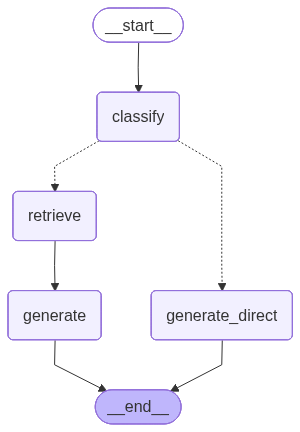


4. Graph Structure:
------------------------------------------------------------
Nodes: ['__start__', 'classify', 'retrieve', 'generate', 'generate_direct', '__end__']
Number of edges: 6
First node: __start__
Last node: __end__


In [103]:
# Visualize the graph
print("=" * 60)
print("GRAPH VISUALIZATION")
print("=" * 60)

# Method 1: ASCII Art (simple text visualization)
print("\n1. ASCII Visualization:")
print("-" * 60)
try:
    graph_repr = agent.get_graph()
    print(graph_repr.print_ascii())
except Exception as e:
    print(f"ASCII visualization not available: {e}")

# Method 2: Mermaid Diagram (for notebooks or markdown)
print("\n2. Mermaid Diagram:")
print("-" * 60)
try:
    graph_repr = agent.get_graph()
    mermaid_diagram = graph_repr.draw_mermaid()
    print(mermaid_diagram)
    print("\n(You can copy this Mermaid code and paste it into https://mermaid.live/ to see the visual diagram)")
except Exception as e:
    print(f"Mermaid visualization not available: {e}")

# Method 3: Save as PNG (optional)
print("\n3. PNG Image:")
print("-" * 60)
try:
    graph_repr = agent.get_graph()
    png_bytes = graph_repr.draw_mermaid_png(output_file_path="livestock_graph.png")
    print("Graph saved as 'livestock_graph.png'")
    print(f"Image size: {len(png_bytes)} bytes")
    
    # Display in notebook if IPython is available
    try:
        from IPython.display import Image, display
        display(Image(png_bytes))
    except ImportError:
        print("(Install IPython to display image in notebook)")
except Exception as e:
    print(f"PNG visualization not available: {e}")

# Method 4: Print graph structure
print("\n4. Graph Structure:")
print("-" * 60)
graph_repr = agent.get_graph()
print(f"Nodes: {list(graph_repr.nodes.keys())}")
print(f"Number of edges: {len(graph_repr.edges)}")
print(f"First node: {graph_repr.first_node().id if graph_repr.first_node() else 'None'}")
print(f"Last node: {graph_repr.last_node().id if graph_repr.last_node() else 'None'}")

## 6. Chat Interface

In [104]:
def chat(user_input: str, thread_id: str = "default") -> str:
    """
    Send a message to the chatbot and get a response.

    Args:
        user_input: The user's message
        thread_id: Session/thread identifier for conversation memory

    Returns:
        The agent's response
    """
    config = {"configurable": {"thread_id": thread_id}}

    # Get current state to preserve message history
    current_state = agent.get_state(config)
    messages = current_state.values.get("messages", []) if current_state.values else []

    # Run the agent
    result = agent.invoke(
        {"user_input": user_input, "messages": messages},
        config
    )

    return result.get("response", "I apologize, but I couldn't generate a response.")


def initialize():
    """Initialize the RAG system by indexing the database."""
    print("[Agent] Initializing RAG system...")
    count = rag.index_database()
    try:
        summary = db.get_database_summary()
        print(f"[Agent] Ready! Database: {summary['total_species']} species, {summary['total_breeds']} breeds")
    except Exception:
        print("[Agent] Ready! (SQL database unavailable)")
    return count

In [105]:
# Check the service account email from credentials
import os
from google.oauth2 import service_account

cred_path = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")
if cred_path:
    creds = service_account.Credentials.from_service_account_file(cred_path)
    print(f"Service account from credentials: {creds.service_account_email}")
    print(f"Expected: vertex-express@animated-flare-421518.iam.gserviceaccount.com")
    print(f"Match: {creds.service_account_email == 'vertex-express@animated-flare-421518.iam.gserviceaccount.com'}")

Service account from credentials: vertex-express@animated-flare-421518.iam.gserviceaccount.com
Expected: vertex-express@animated-flare-421518.iam.gserviceaccount.com
Match: True


In [106]:
# Force reinitialize
rag._db = None
# Then try again
initialize()

[Agent] Initializing RAG system...
[RAG] Loaded credentials from credentials\animated-flare-421518-8be5041fab40.json
[RAG] Firestore client initialized with explicit credentials
[RAG] Connected to Firestore (Project: animated-flare-421518, Database: charlie)
[RAG] Using existing Firestore index (2029 documents)
[DB] Connection failed: (20009, b'DB-Lib error message 20009, severity 9:\nUnable to connect: Adaptive Server is unavailable or does not exist (34.70.16.88)\nNet-Lib error during Unknown error (10060)\nDB-Lib error message 20009, severity 9:\nUnable to connect: Adaptive Server is unavailable or does not exist (34.70.16.88)\nNet-Lib error during Unknown error (10060)\n')
[Agent] Ready! (SQL database unavailable)


2029

## 7. Initialize & Test the Chatbot

In [107]:
# Initialize the system
initialize()

[Agent] Initializing RAG system...
[RAG] Using existing Firestore index (2029 documents)
[DB] Connection failed: (20009, b'DB-Lib error message 20009, severity 9:\nUnable to connect: Adaptive Server is unavailable or does not exist (34.70.16.88)\nNet-Lib error during Unknown error (10060)\nDB-Lib error message 20009, severity 9:\nUnable to connect: Adaptive Server is unavailable or does not exist (34.70.16.88)\nNet-Lib error during Unknown error (10060)\n')
[Agent] Ready! (SQL database unavailable)


2029

In [108]:
# Test with a livestock-related question
response = chat("What cattle breeds are available for dairy production?")
print("Response:")
print(response)

[Agent] Query classified as: livestock
Response:
Here are some cattle breeds known for dairy production, according to the database:

*   **Holstein Friesian:** Known as the world's highest-producing dairy animals.
*   **Dairy Shorthorn:** A breed with roots in Britain, selectively bred for dairy purposes.
*   **Sahiwal:** A zebu breed from the Punjab region, known for its calm demeanor and high milk production, especially in hot climates.
*   **American Brown Swiss:** Revered for its unrivaled milk production and esteemed status as one of the most efficient milk producers among dairy breeds.
*   **Black Pied:** Known for their high milk production and good milk quality.
*   **Danish Jersey:** Known for their high quality dairy production and their distinctive appearance.
*   **Illawarras:** Produce large quantities of milk with moderate fat and high protein.
*   **Butana:** A dairy breed from eastern Africa.


In [109]:
# Test with a general question
response = chat("What's the weather like to day?")
print("Response:")
print(response)

[Agent] Query classified as: general
Response:
I am sorry, I do not have access to real-time information, including weather. To find out the weather, please check a reliable weather app or your local news.



In [110]:
# Interactive chat loop (optional)
def interactive_chat():
    """Run an interactive chat session."""
    print("=" * 50)
    print("Livestock Advisor Chatbot")
    print("Type 'quit' to exit")
    print("=" * 50)
    
    thread_id = f"interactive_{int(__import__('time').time())}"
    
    while True:
        user_input = input("\nYou: ").strip()
        
        if user_input.lower() in ['quit', 'exit', 'q']:
            print("Goodbye!")
            break
        
        if not user_input:
            continue
        
        response = chat(user_input, thread_id)
        print(f"\nAssistant: {response}")

# Uncomment to run interactive chat
# interactive_chat()